<a href="https://colab.research.google.com/github/shub-codes/HateSpeechDetection/blob/main/Hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/thedevastator/hate-speech-and-offensive-language-detection")

<h1> 1) importing libraries</h1>
<ol>
<li>pandas: This module is used for data manipulation and analysis. It provides flexible data structures, including the DataFrame, which allows you to read, write, and perform operations on tabular data such as CSV files in your case.

<li>re (regex): This module is used for working with regular expressions in Python. Regular expressions are sequences of characters used for searching and manipulating text strings. In your code, it is used to detect specific patterns such as usernames, URLs, and HTML entities in the text.

<li>nltk (Natural Language Toolkit): It is a popular Python library for natural language processing. It provides various functionalities and linguistic resources for working with text data. In your code, it is used to perform word tokenization, which means splitting a sentence into individual words or tokens.

<li>nltk.corpus.stopwords: This is a sub-module of NLTK that contains a list of commonly used words called "stop words." These words are typically empty or uninformative words such as "the," "and," "but," etc. They are often removed during text processing to reduce noise and improve performance.

<li>sklearn.model_selection.train_test_split: It is a function from scikit-learn that allows you to split data into training and test sets. This is often used to evaluate the performance of a model by reserving a portion of the data for testing.

<li>tensorflow.keras.preprocessing.text.Tokenizer: This is a class from TensorFlow-Keras used to convert text into sequences of integers. It is useful for text vectorization before feeding it to a machine learning model.

<li>tensorflow.keras.preprocessing.sequence.pad_sequences: This function from TensorFlow-Keras is used to pad sequences of integers to a uniform length. It is often used to prepare text data before using it in neural network models.

<li>tensorflow.keras.models.Sequential: It is a class from TensorFlow-Keras that allows you to create sequential neural network models, where layers are stacked on top of each other in a specific order.

<li>tensorflow.keras.layers.Embedding: This layer in TensorFlow-Keras is used for word representation as dense vectors in a reduced-dimensional space. It is often used as the first layer in natural language processing models.

<li>tensorflow.keras.layers.LSTM: It is a recurrent neural network (RNN) layer called Long Short-Term Memory (LSTM). It is used for sequence processing and is particularly suitable for text analysis.

<li>tensorflow.keras.layers.Dense: This layer in TensorFlow-Keras is a fully connected dense layer, where each neuron is connected to all neurons in the previous layer. It is used to represent fully connected layers in a neural network.

<li>tensorflow.keras.layers.Dropout: This layer in TensorFlow-Keras is used to apply a regularization technique called "dropout." It randomly deactivates some neurons during training, which helps prevent overfitting of the model.

<li>keras.utils.to_categorical: This function from Keras is used to convert categorical variables into binary variables. It is often used to convert labels or classes into one-hot encoding.

<li>keras.backend: It is a Keras module that provides low-level functions and operations to interact with the underlying backend, such as TensorFlow in this case.





In [ ]:
import pandas as pd #to read and write csv files
import numpy as np
import nltk
nltk.download('stopwords') # natural language toolkit
nltk.download('punkt_tab')
nltk.download('wordnet')
import re #regular expressions
import tensorflow as tf
from nltk.corpus import stopwords # to remove words like a, the,is etc. such words contribute almost nothing
from nltk.stem import WordNetLemmatizer # to impplement lemmitisation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import backend as K


<h1> 2) Importing and reading data

In [6]:
df=pd.read_csv("/content/hate-speech-and-offensive-language-detection/train.csv")
print(df.head(5))
# print(f"df has {df.shape[0]}  rows and {df.shape[1]} cols")
tweet=df['tweet']
labels=df['class']
for head in df.columns[:-1]:
  print(f"{head}")
  print(f"null values = {df[head].isnull().sum()}")
  print(f"description of {head} is as follows {df[head].describe()}")

   count  hate_speech_count  offensive_language_count  neither_count  class  \
0      3                  0                         0              3      2   
1      3                  0                         3              0      1   
2      3                  0                         3              0      1   
3      3                  0                         2              1      1   
4      6                  0                         6              0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
count
null values = 0
description of count is as follows count    24783.000000
mean         3.243473
std          0.883060
min          3.000000
25%          3.000000
50%          3.000000
75%   

<h2> plotting dataset</h2>

                          hate_speech_count  offensive_language_count  \
hate_speech_count                  1.000000                 -0.261808   
offensive_language_count          -0.261808                  1.000000   
neither_count                     -0.157599                 -0.684406   
class                             -0.515732                 -0.410440   

                          neither_count     class  
hate_speech_count             -0.157599 -0.515732  
offensive_language_count      -0.684406 -0.410440  
neither_count                  1.000000  0.800687  
class                          0.800687  1.000000  


<Axes: >

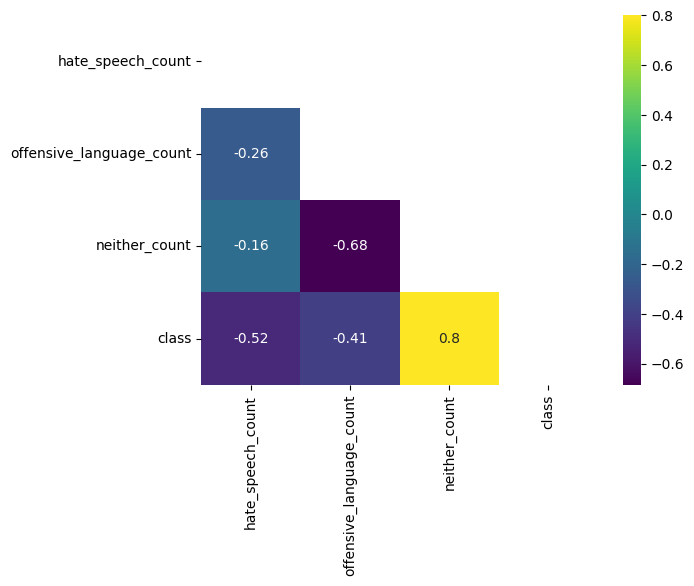

In [7]:
import seaborn as sns
df_corr=df.drop(columns=[df.columns[-1],df.columns[0]])
df_corr=df_corr.corr()
mask=np.triu(np.ones_like(df_corr))
print(df_corr)
sns.heatmap(df_corr,annot=True,mask=mask,cmap="viridis")


<h1> 3) CLEANING THE DATA USING REGULAR EXPRESSIONS </h1>
<h3> implement lemmitisation function after initial model training. compare the results with and without lemmitisation. compare runtime, accuracy and f1 score

In [20]:
stopWords= set(stopwords.words('english'))
stopWords.add('RT') # to add the RT which means retweet
#remove html entity
def remove_entity(raw_text):
  text_regex= r"&(#\d+|#x[a-fA-F0-9]+|[a-zA-Z]+);"
  updated_text=re.sub(text_regex,"",raw_text)
  return updated_text
# removes user tags
def remove_user_tags(raw_text):
  user_regex=r"@([^ ]+)"
  updated_text=re.sub(user_regex,"user",raw_text)
  return updated_text
# removes urls
def remove_urls(raw_text):
  url_regex=r"https?://\S+|www\.\S+"
  updated_text=re.sub(url_regex,"",raw_text,flags=re.IGNORECASE)
  return updated_text
# to remove unnecessary markings
def remove_noise(raw_text):
  noise_regex=r"['\"!`]|\.{2,}"
  updated_text=re.sub(noise_regex,"",raw_text)
  return updated_text
# to tokenise the string and remove stopwords
def remove_stopwords(raw_text):
  tokenize= nltk.word_tokenize(raw_text)
  updated_text=[word for word in tokenize if word not in stopWords]
  return " ".join(updated_text)
# implement this lemmatizer ony after initial model training. After implementing, check for any changes in results
def lemmatize(raw_text):
  lemmatizer=WordNetLemmatizer()
  tokenise=nltk.tokenize.word_tokenize(raw_text)
  lemminised_words=[lemmatizer.lemmatize(word) for word in tokenise]
  return " ".join(lemminised_words)
# calling all the above functions
def preprocess(raw_text):
  updated=[]
  updated=[remove_entity(text) for text in raw_text]
  updated=[remove_user_tags(text) for text in updated]
  updated=[remove_urls(text) for text in updated]
  updated=[remove_noise(text) for text in updated]
  updated=[remove_stopwords(text) for text in updated]
  updated=[lemmatize(text) for text in updated ]
  return updated


In [98]:
updated_tweet=preprocess(tweet)

<h2> Explaination of regex given above</h2>
<ul>
<li> <h3> HTML func regex = r"&(#\d+|#x[a-fA-F0-9]+|[a-zA-Z]+)
  <ul> <li>r stands to tell that the text is raw
      <li>  #\d tells for numeric references eg &#12345
      <li> #x[a-fA-F0-9] tells for hexadecimal numeric references
      <li> [a-zA-Z] mathces named entities &amp, &lt
  </ul>
<li><h3> user tags func = r"@\w+"
  <ul> <li> \w stands for  all alphanumeric letters and _
        <li> example "Hey @john_doe, check this out! Also, @alice123 and @user.test are here." changes to "Hey user, check this out! Also, user and user are here."
  </ul>
<li><h3> url func = r"https?://\S+|www\.\S+"
  <ul> <li> https? means the s in last is optional. hence it mathces to both http and https.
      <li> \S+ matches any additional string
      <li> www\.\S+ matches for all url in for www.dsfdjskn.com
      <li> flag=re.IGNORECASE means it matches irrespective of case of letters
  </ul>
<li> <h3> remove noise func
  <ul> <li> removes ", ', !' or two and more dots
  </ul>


<h1> 4) splitting the data into training and testing</h1>


<h3> Building vocabulary</h3>
*   Vocabulary= number of unique words in dataset
*   build the vocabulary based on training dataset



In [119]:
x_train,x_test,y_train,y_test=train_test_split(updated_tweet,labels,train_size=0.80,random_state=40)
tokenizer=Tokenizer() #creates an instance of keras tokenizer
tokenizer.fit_on_texts(x_train) # mathces each unique word in x_train to integer index--> builds a vocabulary
x_train=tokenizer.texts_to_sequences(x_train) #convert all words in x_train to index from vocabulary
x_test=tokenizer.texts_to_sequences(x_test)


 <h3> Padding the data</h3>
 we need to pad the training and testing data as neural networks require the inputs to be of equal lenght. we can take the maximul length of any sequence, whether in training or testing data( hence orignal unsplit data is used)

In [120]:
max_len = max(len(seq) for seq in x_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in x_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")
x_train=pad_sequences(x_train, maxlen=max_len,padding='post')
x_test=pad_sequences(x_test, maxlen=max_len,padding='post')

<h3> One Hot Encoding</h3>
One hot encoding is used for followig purposes


*   Neural Networks expect categorical outputs in OHE format
*   OHE treats them as independet categories. Example : avoids mistake of comparing 2>1>0 as they are non comparable



In [121]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

<h1> 5) model Building</h1>

<ol>
<li>recall(y_true, y_pred):
<ul>
<li>K.round(K.clip(y_true * y_pred, 0, 1)): This operation element-wise multiplies the true labels (y_true) and the model predictions (y_pred), and then rounds the results to the nearest integer. The K.clip() function is used to limit the resulting values between 0 and 1, keeping only the binary values. This yields a matrix of the same shape as y_true and y_pred, with 1s for true positives and 0s for other cases.

<li>K.sum(K.round(K.clip(y_true * y_pred, 0, 1))): This operation calculates the sum of all elements in the matrix obtained in the previous step, giving the total number of true positives.

<li>K.sum(K.round(K.clip(y_true, 0, 1))): This operation calculates the sum of all elements in the y_true matrix, after rounding and clipping between 0 and 1. This corresponds to the total number of actual positives.

<li>recall = true_p/ (actual_p): This operation calculates recall by dividing the number of true positives by the total number of actual positives.
</ul>
<li>precision(y_true, y_pred):
<ul>
<li>K.round(K.clip(y_true * y_pred, 0, 1)): This operation is similar to the one in recall(). It element-wise multiplies the true labels (y_true) and the model predictions (y_pred), and then rounds the results to the nearest integer. The K.clip() function is used to limit the resulting values between 0 and 1.

<li>K.sum(K.round(K.clip(y_true * y_pred, 0, 1))): This operation calculates the total number of true positives.

<li>K.sum(K.round(K.clip(y_pred, 0, 1))): This operation calculates the sum of all elements in the y_pred matrix, after rounding and clipping between 0 and 1. This corresponds to the total number of samples predicted as positives by the model.

<li>precision = true_p / (predicted_p): This operation calculates precision by dividing the number of true positives by the total number of samples predicted as positives.
</ul>
<li>f1(y_true, y_pred):
<ul>
<li>precision = precision(y_true, y_pred): This operation calls the precision() function to calculate precision.

<li>recall = recall(y_true, y_pred): This operation calls the recall() function to calculate recall.

<li>f1 = 2 * ((precisions * recalls) / (precisions + recalls)): This operation uses the precision (precisions) and recall (recalls) values to calculate the F1 score.  The F1 score is a combined measure of precision and recall, providing an overall indication of the performance of a binary classification model.

In [122]:
def recall(y_test, y_pred):
    true_p = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_test * y_pred, 0, 1)))
    actual_p = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_test, 0, 1)))
    # Use tf.cond for conditional logic in TensorFlow
    return tf.cond(tf.equal(actual_p, 0), lambda: 0.0, lambda: true_p / actual_p)

def precision(y_test, y_pred):
    true_p = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_test * y_pred, 0, 1)))
    predicted_p = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_pred, 0, 1)))
    # Use tf.cond for conditional logic in TensorFlow
    return tf.cond(tf.equal(predicted_p, 0), lambda: 0.0, lambda: true_p / predicted_p)

def f1(y_test, y_pred):
    precisions = precision(y_test, y_pred)
    recalls = recall(y_test, y_pred)
    # Use tf.cond for conditional logic in TensorFlow
    return tf.cond(tf.equal(precisions + recalls, 0), lambda: 0.0, lambda: 2 * (precisions * recalls) / (precisions + recalls))

<h2> Definitions and need </h2>
<h3>output_dim</h3> it mentions how many features is a word is defind against. It essentially determines the number of dimension in which the word vector is represented. The model will learn these representations during training.Larger values capture more information but also increase computational cost.
<h3>sequential</h3> as a lstm is a sequential model


<h1> Defining and building the model

In [124]:
output_dim=200
vocab_size=len(tokenizer.word_index)+1
lstm_model=Sequential([
    Embedding(vocab_size,output_dim,input_length=max_len),
    LSTM(64,dropout=0.3,recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(128,activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
])


In [125]:
lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',precision,recall,f1])
lstm_model.build(input_shape=(None, max_len))

In [126]:
lstm_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 28, 200)        │     3,578,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 64)             │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,654,947 (13.94 MB)

 Trainable params: 3,654,947 (13.94 MB)

 Non-trainable params: 0 (0.00 B)

<h2> Explaination of above output</h2>
<ol>
<li> <h3> embeddings <h3>
<ul> <li> each of 28 tokens map to a 200 dimensional vector
      <li> param= vocab_size*output_dim
</ul>
<li><h3>lstm</h3>
<ul><li> x=hidden layers<li> param=(input_dim+x+1)*4*x<li> Why ×4? LSTM has 4 gates (input, forget, cell, output), each with its own weights.
</ul>
<li>Dense_6=>param=input*neurons+biases
<li> dense_7=> param=128*3+3




<h1> Training the model

In [127]:
model_training=lstm_model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.7795 - f1: 0.7459 - loss: 0.6574 - precision: 0.7660 - recall: 0.7303 - val_accuracy: 0.8713 - val_f1: 0.8722 - val_loss: 0.3804 - val_precision: 0.8816 - val_recall: 0.8632
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.8897 - f1: 0.8878 - loss: 0.3542 - precision: 0.9063 - recall: 0.8706 - val_accuracy: 0.8919 - val_f1: 0.8925 - val_loss: 0.3214 - val_precision: 0.9084 - val_recall: 0.8777
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9173 - f1: 0.9176 - loss: 0.2665 - precision: 0.9306 - recall: 0.9053 - val_accuracy: 0.8921 - val_f1: 0.8931 - val_loss: 0.3484 - val_precision: 0.9006 - val_recall: 0.8860
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.9309 - f1: 0.9313 - loss: 0.2025 - precision: 0.9411 - recall: 0.9220 - val_accuracy: 0.8929 - val_f1: 0.8926 - val_loss: 0.3523 - val_precision: 0.9083 - val_recall: 0.8777
Epoch 5/10
620/620 ━━━━━━━━━━━━━

<h2> imp infor on results</h2>
f1,accuracy,recall and precisons are values for training data while val_f1, val_precision and others are for testing data

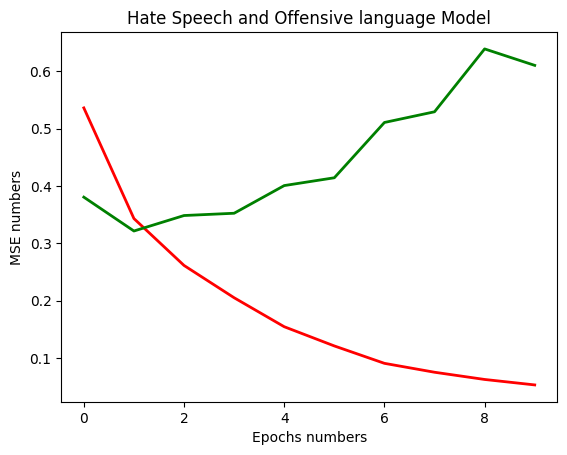

In [128]:
import matplotlib.pyplot as plt
hist = lstm_model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()